In [1]:
# GEREKLİ KÜTÜPHANELER
!pip install lightgbm optuna imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.combine import SMOTEENN
from lightgbm import LGBMClassifier
import optuna

# VERİYİ YÜKLE
df = pd.read_csv("loans_with_target.csv")

# GEREKSİZ SÜTUNLARI AT
df.drop(columns=[
    "emp_title", "loan_status", "issue_month",
    "verification_income_joint", "annual_income_joint", "debt_to_income_joint"
], inplace=True)

# ÖZELLİK MÜHENDİSLİĞİ
df["loan_to_income"] = df["loan_amount"] / (df["annual_income"] + 1)
df["credit_util_ratio"] = df["total_credit_utilized"] / (df["total_credit_limit"] + 1)
df["paid_ratio"] = df["paid_total"] / (df["loan_amount"] + 1)
df["log_income"] = np.log1p(df["annual_income"])
df["log_balance"] = np.log1p(df["balance"])

# EKSİK VERİ KONTROLÜ
missing = df.isnull().mean()
df = df[missing[missing <= 0.25].index]
df = df.fillna(df.median(numeric_only=True))

# ONE-HOT ENCODING
cat_cols = df.select_dtypes(include="object").columns.tolist()
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# X ve y
X = df.drop("is_default", axis=1)
y = df["is_default"]

# TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTEENN UYGULA
sampler = SMOTEENN(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

# OPTUNA İLE HİPERPARAMETRE ARAMA
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    model.fit(X_resampled, y_resampled)
    preds = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# EN İYİ MODELİ EĞİT
best_params = study.best_params
best_params['random_state'] = 42
model = LGBMClassifier(**best_params)
model.fit(X_resampled, y_resampled)

# TAHMİN VE METRİKLER
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
roc = roc_auc_score(y_test, y_proba)

print("✔️ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print(f"🎯 Accuracy: {accuracy:.4f}")
print(f"❌ Error Rate: {error_rate:.4f}")
print(f"🏁 ROC AUC: {roc:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.7 MB/s eta 0:00:00


[I 2025-04-02 13:41:08,572] A new study created in memory with name: no-name-2c9cc3f4-c66a-4cb3-bf21-4ef2f70093e6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6265
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:11,175] Trial 0 finished with value: 0.8633740665308893 and parameters: {'n_estimators': 272, 'max_depth': 7, 'learning_rate': 0.05393983733266803, 'num_leaves': 30, 'min_child_samples': 71, 'subsample': 0.9934308688320869, 'colsample_bytree': 0.7091080571028117}. Best is trial 0 with value: 0.8633740665308893.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6265
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:13,948] Trial 1 finished with value: 0.8700214980764879 and parameters: {'n_estimators': 234, 'max_depth': 10, 'learning_rate': 0.1689425258687034, 'num_leaves': 51, 'min_child_samples': 71, 'subsample': 0.9475513343423083, 'colsample_bytree': 0.9480766851129259}. Best is trial 1 with value: 0.8700214980764879.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:18,418] Trial 2 finished with value: 0.8720440144829147 and parameters: {'n_estimators': 497, 'max_depth': 8, 'learning_rate': 0.1296735482321387, 'num_leaves': 28, 'min_child_samples': 88, 'subsample': 0.7134724340272924, 'colsample_bytree': 0.8328165649025392}. Best is trial 2 with value: 0.8720440144829147.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6265
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:41:22,608] Trial 3 finished with value: 0.8839811043222447 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.010026060334914441, 'num_leaves': 37, 'min_child_samples': 63, 'subsample': 0.8001418325005252, 'colsample_bytree': 0.8114206536142209}. Best is trial 3 with value: 0.8839811043222447.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6265
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:26,713] Trial 4 finished with value: 0.8694699026929169 and parameters: {'n_estimators': 323, 'max_depth': 9, 'learning_rate': 0.15124245248232573, 'num_leaves': 77, 'min_child_samples': 70, 'subsample': 0.5416377329794808, 'colsample_bytree': 0.598059403318725}. Best is trial 3 with value: 0.8839811043222447.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6285
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:41:29,493] Trial 5 finished with value: 0.860418081013804 and parameters: {'n_estimators': 279, 'max_depth': 8, 'learning_rate': 0.06379775153532223, 'num_leaves': 26, 'min_child_samples': 12, 'subsample': 0.9525194228102196, 'colsample_bytree': 0.8621998742287653}. Best is trial 3 with value: 0.8839811043222447.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:34,109] Trial 6 finished with value: 0.8451997058157955 and parameters: {'n_estimators': 468, 'max_depth': 6, 'learning_rate': 0.16649633381631657, 'num_leaves': 34, 'min_child_samples': 44, 'subsample': 0.5236926426331834, 'colsample_bytree': 0.5595815313653009}. Best is trial 3 with value: 0.8839811043222447.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6263
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:37,864] Trial 7 finished with value: 0.8845044127630686 and parameters: {'n_estimators': 407, 'max_depth': 8, 'learning_rate': 0.012398154739529745, 'num_leaves': 53, 'min_child_samples': 77, 'subsample': 0.6010888596023626, 'colsample_bytree': 0.7223322909164887}. Best is trial 7 with value: 0.8845044127630686.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:41:39,709] Trial 8 finished with value: 0.8626810364335822 and parameters: {'n_estimators': 233, 'max_depth': 9, 'learning_rate': 0.13426843349482803, 'num_leaves': 29, 'min_child_samples': 53, 'subsample': 0.9004931000560819, 'colsample_bytree': 0.6388021869191793}. Best is trial 7 with value: 0.8845044127630686.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6275
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:42,092] Trial 9 finished with value: 0.8793420457116995 and parameters: {'n_estimators': 343, 'max_depth': 9, 'learning_rate': 0.1924866406122316, 'num_leaves': 91, 'min_child_samples': 32, 'subsample': 0.5376636664527257, 'colsample_bytree': 0.6565209552980007}. Best is trial 7 with value: 0.8845044127630686.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6253
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:43,090] Trial 10 finished with value: 0.8534382778909255 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.014248277688800604, 'num_leaves': 61, 'min_child_samples': 100, 'subsample': 0.6600057639979382, 'colsample_bytree': 0.9891955101439771}. Best is trial 7 with value: 0.8845044127630686.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 13:41:46,732] Trial 11 finished with value: 0.8930046390586105 and parameters: {'n_estimators': 389, 'max_depth': 12, 'learning_rate': 0.010145244826343242, 'num_leaves': 49, 'min_child_samples': 83, 'subsample': 0.8323574213727228, 'colsample_bytree': 0.7846930508372884}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:49,917] Trial 12 finished with value: 0.8683242815116543 and parameters: {'n_estimators': 412, 'max_depth': 12, 'learning_rate': 0.053729494734735324, 'num_leaves': 57, 'min_child_samples': 87, 'subsample': 0.8145327589043416, 'colsample_bytree': 0.7422518062702}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:53,063] Trial 13 finished with value: 0.8678009730708305 and parameters: {'n_estimators': 412, 'max_depth': 12, 'learning_rate': 0.08478839948581539, 'num_leaves': 71, 'min_child_samples': 86, 'subsample': 0.6262655576130155, 'colsample_bytree': 0.7675717649259112}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6253
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:56,754] Trial 14 finished with value: 0.8841508259787283 and parameters: {'n_estimators': 415, 'max_depth': 11, 'learning_rate': 0.038619076790450874, 'num_leaves': 46, 'min_child_samples': 95, 'subsample': 0.845395632524151, 'colsample_bytree': 0.9102064012824707}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6263
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:41:58,913] Trial 15 finished with value: 0.8453835709436525 and parameters: {'n_estimators': 449, 'max_depth': 5, 'learning_rate': 0.09648295572872337, 'num_leaves': 44, 'min_child_samples': 80, 'subsample': 0.736491828416546, 'colsample_bytree': 0.7037877429760705}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:42:02,189] Trial 16 finished with value: 0.8646894093686355 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.03151313369045679, 'num_leaves': 67, 'min_child_samples': 52, 'subsample': 0.6186881451457853, 'colsample_bytree': 0.5047255764681575}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6263
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:42:03,877] Trial 17 finished with value: 0.8814352794749944 and parameters: {'n_estimators': 161, 'max_depth': 11, 'learning_rate': 0.07184352403169318, 'num_leaves': 90, 'min_child_samples': 77, 'subsample': 0.6839777054031537, 'colsample_bytree': 0.785323289753011}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:05,694] Trial 18 finished with value: 0.8691163159085766 and parameters: {'n_estimators': 381, 'max_depth': 7, 'learning_rate': 0.030880548116080056, 'num_leaves': 20, 'min_child_samples': 62, 'subsample': 0.7622181555293251, 'colsample_bytree': 0.8576271651687217}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-04-02 13:42:09,790] Trial 19 finished with value: 0.8859753337859244 and parameters: {'n_estimators': 451, 'max_depth': 10, 'learning_rate': 0.11013762730760829, 'num_leaves': 80, 'min_child_samples': 40, 'subsample': 0.5834520477396039, 'colsample_bytree': 0.6959329944418392}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6273
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-04-02 13:42:13,652] Trial 20 finished with value: 0.8819020140303235 and parameters: {'n_estimators': 458, 'max_depth': 11, 'learning_rate': 0.1030256420292967, 'num_leaves': 99, 'min_child_samples': 34, 'subsample': 0.8731884719066292, 'colsample_bytree': 0.6634648968312836}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-02 13:42:16,506] Trial 21 finished with value: 0.8737412310477484 and parameters: {'n_estimators': 432, 'max_depth': 10, 'learning_rate': 0.11885207812376586, 'num_leaves': 78, 'min_child_samples': 39, 'subsample': 0.5904726640681501, 'colsample_bytree': 0.7300357706058388}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-04-02 13:42:20,432] Trial 22 finished with value: 0.8675181036433582 and parameters: {'n_estimators': 491, 'max_depth': 10, 'learning_rate': 0.08427595930562166, 'num_leaves': 56, 'min_child_samples': 47, 'subsample': 0.591563206736953, 'colsample_bytree': 0.6783136383481019}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6279
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:24,759] Trial 23 finished with value: 0.8892000452591085 and parameters: {'n_estimators': 389, 'max_depth': 12, 'learning_rate': 0.02174253707602007, 'num_leaves': 42, 'min_child_samples': 17, 'subsample': 0.7762477962606306, 'colsample_bytree': 0.7700590184129081}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6277
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:27,207] Trial 24 finished with value: 0.8895677755148224 and parameters: {'n_estimators': 314, 'max_depth': 12, 'learning_rate': 0.02943331187998751, 'num_leaves': 42, 'min_child_samples': 20, 'subsample': 0.7663485419019289, 'colsample_bytree': 0.773169792255715}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6287
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 139
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:29,647] Trial 25 finished with value: 0.8815484272459833 and parameters: {'n_estimators': 312, 'max_depth': 12, 'learning_rate': 0.03965418627588628, 'num_leaves': 40, 'min_child_samples': 10, 'subsample': 0.766831323853592, 'colsample_bytree': 0.7865613451327513}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6277
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:32,673] Trial 26 finished with value: 0.8852115863317492 and parameters: {'n_estimators': 365, 'max_depth': 12, 'learning_rate': 0.02731746617933167, 'num_leaves': 47, 'min_child_samples': 21, 'subsample': 0.7992741487422454, 'colsample_bytree': 0.8689635768797117}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6277
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:35,371] Trial 27 finished with value: 0.8792006109979634 and parameters: {'n_estimators': 240, 'max_depth': 11, 'learning_rate': 0.05070924353927723, 'num_leaves': 41, 'min_child_samples': 22, 'subsample': 0.843507595441534, 'colsample_bytree': 0.8149858784100902}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6277
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:38,410] Trial 28 finished with value: 0.8845468431771893 and parameters: {'n_estimators': 286, 'max_depth': 12, 'learning_rate': 0.02273146728963512, 'num_leaves': 62, 'min_child_samples': 23, 'subsample': 0.7099854369113954, 'colsample_bytree': 0.9106276022318711}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6279
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719


[I 2025-04-02 13:42:40,694] Trial 29 finished with value: 0.892622765331523 and parameters: {'n_estimators': 329, 'max_depth': 11, 'learning_rate': 0.04627843256819643, 'num_leaves': 34, 'min_child_samples': 17, 'subsample': 0.9212659744162721, 'colsample_bytree': 0.7702743280813131}. Best is trial 11 with value: 0.8930046390586105.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7612, number of negative: 6284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 13896, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547784 -> initscore=0.191719
[LightGBM] [Info] Start training from score 0.191719
✔️ Confusion Matrix:
 [[1948   16]
 [  23   13]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1964
           1       0.45      0.36      0.40        36

    accuracy                           0.98      2000
   macro avg       0.72      0.68      0.70      2000
weighted avg       0.98      0.98      0.98      2000

🎯 Accuracy: 0.9805
❌ Error

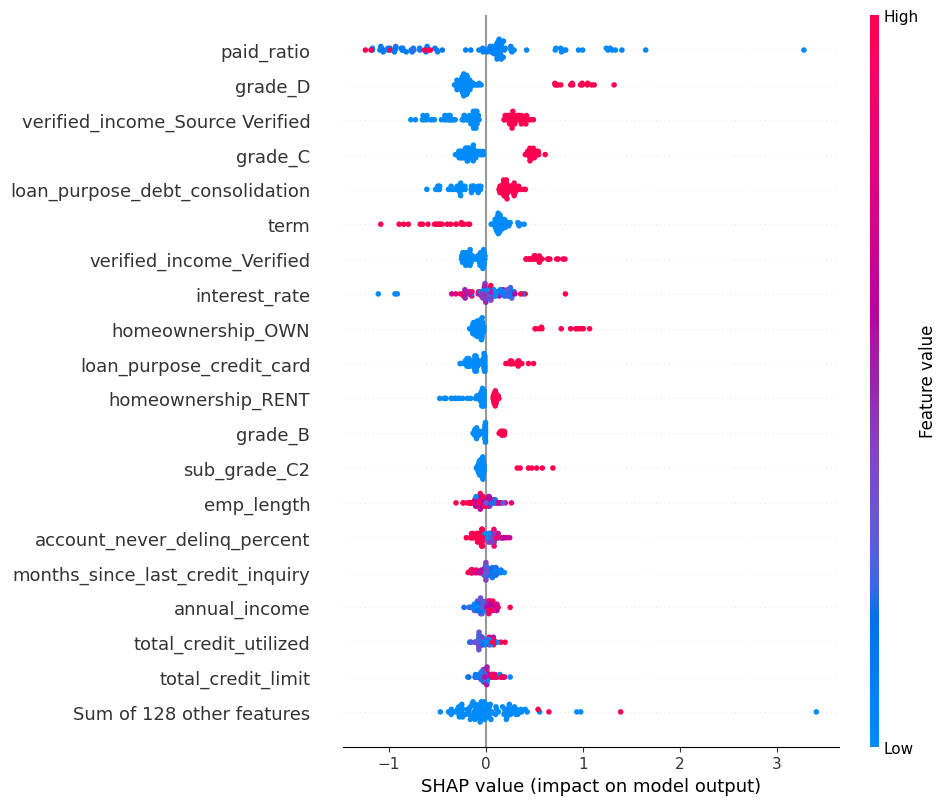

In [2]:
# GEREKİRSE YÜKLE
!pip install shap

import shap
import matplotlib.pyplot as plt

# Giriş verilerini SHAP için float32'ye dönüştür
X_train_shap = X_train.astype("float32")
X_test_shap = X_test.astype("float32")

# SHAP TreeExplainer
explainer = shap.Explainer(model, X_train_shap)

# İlk 100 örnek için SHAP değerlerini hesapla
shap_values = explainer(X_test_shap[:100])

# 📌 Summary Plot (En çok etki eden özellikler)
shap.plots.beeswarm(shap_values, max_display=20)


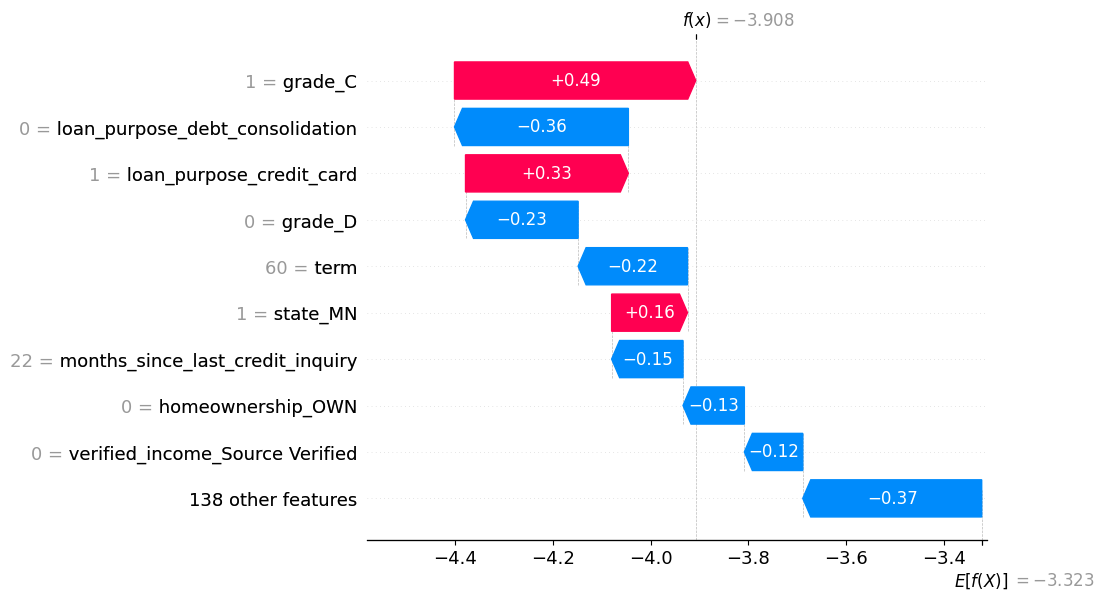

In [5]:
# Örnek: X_test'in ilk satırı için waterfall grafiği
shap.plots.waterfall(shap_values[10])


In [6]:
import joblib

# Eğitilmiş LightGBM modelini dışa aktar
joblib.dump(model, "lightgbm_loan_default_model.pkl")


['lightgbm_loan_default_model.pkl']

In [7]:
# Yüklemek için:
model = joblib.load("lightgbm_loan_default_model.pkl")
